In [1]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/processed.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

# Import Libraries

In [3]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
import tensorflow as tf
import tensorflow_datasets as tfds
import time
from keras import layers, losses, metrics, models, optimizers, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, hamming_loss, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, zero_one_loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Dataset

Hyperparameters

In [4]:
BATCH_SIZE = 16
EPOCH = 20
LEARNING_RATE = 0.0001

Load dataset files (local)

In [ ]:
# Directories
dataset_dir = '../data/processed'
model_dir = '../models'

train_dir = f'{dataset_dir}/train'
val_dir = f'{dataset_dir}/valid'
test_dir = f'{dataset_dir}/test'

train_img_dir = f'{train_dir}/images'
val_img_dir = f'{val_dir}/images'
test_img_dir = f'{test_dir}/images'

# Label files
df_train = pd.read_csv(f'{train_dir}/labels.csv')
df_val = pd.read_csv(f'{val_dir}/labels.csv')
df_test = pd.read_csv(f'{test_dir}/labels.csv')

df_train.columns = [df_train.columns[0]] + [col[1:] for col in df_train.columns[1:]]
df_val.columns = [df_val.columns[0]] + [col[1:] for col in df_val.columns[1:]]
df_test.columns = [df_test.columns[0]] + [col[1:] for col in df_test.columns[1:]]

# Dataset metadata
NUM_CLASSES = len(df_train.columns) - 1
DATASET_COLS = [str(obj) for obj in df_train.columns[1:]]

# Generate data from DataFrames
SEED = 42
WIDTH, HEIGHT = 224, 224
datagen = ImageDataGenerator()

train_ds = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    class_mode='raw'
)
val_ds = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    class_mode='raw'
)
test_ds = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=1,
    seed=SEED,
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    class_mode=None
)

Load dataset files (Colab)

In [5]:
# Directories
dataset_dir = '/content/data/processed'
model_dir = '../models'

train_dir = f'{dataset_dir}/train'
val_dir = f'{dataset_dir}/valid'
test_dir = f'{dataset_dir}/test'

train_img_dir = f'{train_dir}/images'
val_img_dir = f'{val_dir}/images'
test_img_dir = f'{test_dir}/images'

# Label files
df_train = pd.read_csv(f'{train_dir}/labels.csv')
df_val = pd.read_csv(f'{val_dir}/labels.csv')
df_test = pd.read_csv(f'{test_dir}/labels.csv')

df_train.columns = [df_train.columns[0]] + [col[1:] for col in df_train.columns[1:]]
df_val.columns = [df_val.columns[0]] + [col[1:] for col in df_val.columns[1:]]
df_test.columns = [df_test.columns[0]] + [col[1:] for col in df_test.columns[1:]]

# Dataset metadata
NUM_CLASSES = len(df_train.columns) - 1
DATASET_COLS = [str(obj) for obj in df_train.columns[1:]]

# Generate data from DataFrames
SEED = 42
WIDTH, HEIGHT = 224, 224
datagen = ImageDataGenerator()

print('Batch size:', BATCH_SIZE)

train_ds = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    class_mode='raw'
)
val_ds = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    class_mode='raw'
)
test_ds = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_img_dir,
    x_col='filename',
    y_col=DATASET_COLS,
    batch_size=1,
    seed=SEED,
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    class_mode='raw'
)

Batch size: 16
Found 5916 validated image filenames.
Found 123 validated image filenames.
Found 123 validated image filenames.


# Build Model

In [6]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


Load model (optional)

In [ ]:
emeowtions_model = keras.saving.load_model(f'{model_dir}/checkpoints/emeowtionsv1.keras')

https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24

Choose MobileNetV3Small or MobileNetV3Large

In [7]:
mobilenet = keras.applications.MobileNetV3Small(
    weights='imagenet', # Load pre-trained weights from ImageNet
    input_shape=(224, 224, 3),
    include_top=False   # Exclude ImageNet top classifiers
)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobilenet = keras.applications.MobileNetV3Large(
    weights='imagenet', # Load pre-trained weights from ImageNet
    input_shape=(224, 224, 3),
    include_top=False   # Exclude ImageNet top classifiers
)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [21]:
time_callback = TimeHistory()

# Unfreeze the top layers of MobileNet
for layer in mobilenet.layers[-10:]:
  layer.trainable = True

# Build custom multi-label classification mode on top of the MobileNetV3 base model,
# this replaces the top layers of the base model
emeowtions_model = keras.models.Sequential([
    mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

# Compile model
emeowtions_model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=losses.BinaryCrossentropy(from_logits=False),   # try w/ and w/o logits
    metrics=[
        metrics.BinaryAccuracy(),
        metrics.Precision(),
        metrics.Recall(),
        metrics.F1Score(),
        metrics.AUC()
    ]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train model
history = emeowtions_model.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=val_ds,
    callbacks=[time_callback, early_stopping, reduce_lr],
    verbose=2
)

print('Training Time:', sum(time_callback.times))

Epoch 1/20
370/370 - 128s - 345ms/step - auc_3: 0.7765 - binary_accuracy: 0.6432 - f1_score: 0.2751 - loss: 1.7346 - precision_3: 0.3344 - recall_3: 0.7813 - val_auc_3: 0.8528 - val_binary_accuracy: 0.7173 - val_f1_score: 0.2949 - val_loss: 1.5771 - val_precision_3: 0.3960 - val_recall_3: 0.8238 - learning_rate: 1.0000e-04
Epoch 2/20
370/370 - 10s - 27ms/step - auc_3: 0.9243 - binary_accuracy: 0.7565 - f1_score: 0.3821 - loss: 1.4851 - precision_3: 0.4485 - recall_3: 0.9166 - val_auc_3: 0.8840 - val_binary_accuracy: 0.8080 - val_f1_score: 0.3390 - val_loss: 1.4437 - val_precision_3: 0.5084 - val_recall_3: 0.8330 - learning_rate: 1.0000e-04
Epoch 3/20
370/370 - 10s - 28ms/step - auc_3: 0.9570 - binary_accuracy: 0.8194 - f1_score: 0.3944 - loss: 1.3349 - precision_3: 0.5286 - recall_3: 0.9423 - val_auc_3: 0.8906 - val_binary_accuracy: 0.8573 - val_f1_score: 0.3416 - val_loss: 1.3234 - val_precision_3: 0.6027 - val_recall_3: 0.8124 - learning_rate: 1.0000e-04
Epoch 4/20
370/370 - 11s - 30

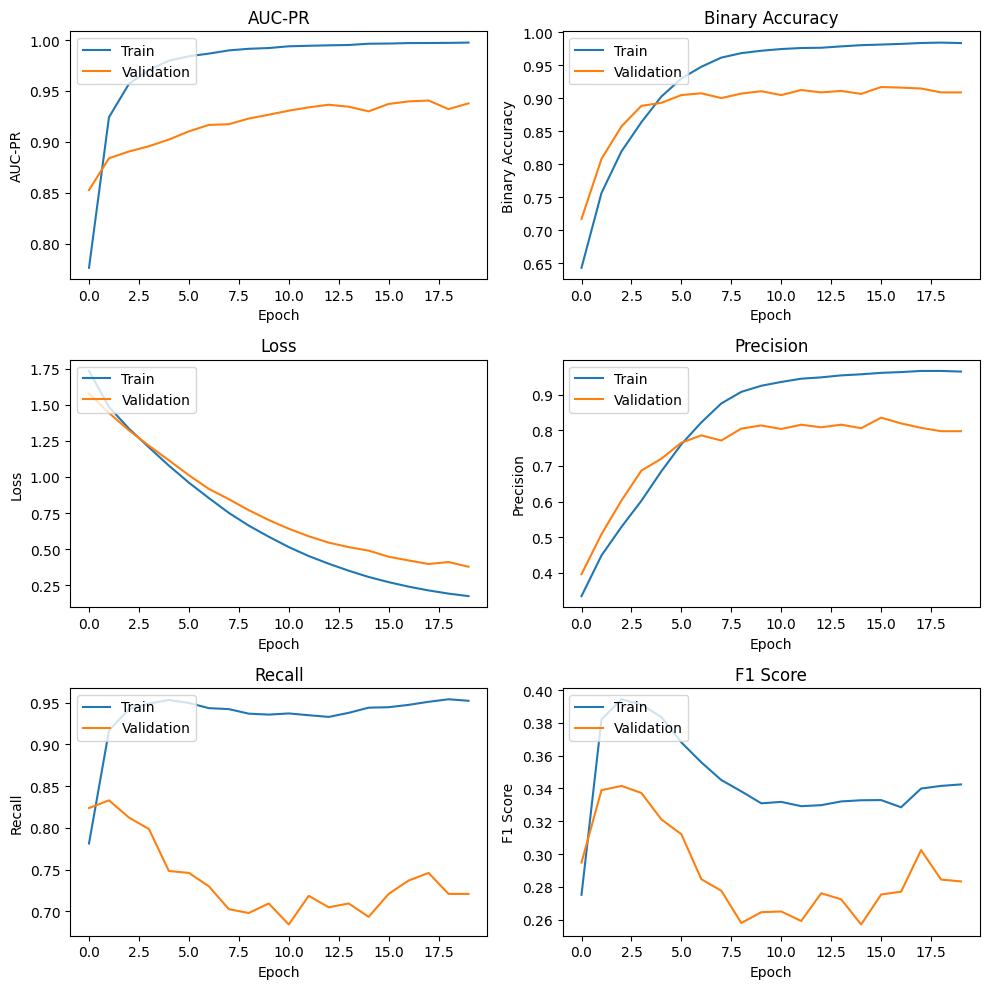

In [23]:
# Plots metric graph
def plot_metric(ax, history, metric_name, title):
    train_metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    if metric_name == 'f1_score':
      f1_scores_np = np.array(train_metric)
      average_f1_scores = np.mean(f1_scores_np, axis=1)
      train_metric = average_f1_scores

      f1_scores_np = np.array(val_metric)
      average_f1_scores = np.mean(f1_scores_np, axis=1)
      val_metric = average_f1_scores

    ax.plot(train_metric)
    ax.plot(val_metric)
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.legend(['Train', 'Validation'], loc='upper left')

# Plot figure
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
ax4 = axes[3]
ax5 = axes[4]
ax6 = axes[5]

plot_metric(ax1, history, 'auc_3', 'AUC-PR')
plot_metric(ax2, history, 'binary_accuracy', 'Binary Accuracy')
plot_metric(ax3, history, 'loss', 'Loss')
plot_metric(ax4, history, 'precision_3', 'Precision')
plot_metric(ax5, history, 'recall_3', 'Recall')
plot_metric(ax6, history, 'f1_score', 'F1 Score')

plt.tight_layout()
plt.show()

# Evaluation

Evaluate model on test set for summarized metrics

In [24]:
x = emeowtions_model.evaluate(
    test_ds,
    batch_size=BATCH_SIZE
)

123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - auc_3: 0.9489 - binary_accuracy: 0.9175 - f1_score: 0.2672 - loss: 0.3488 - precision_3: 0.8229 - recall_3: 0.7423


# Prediction

Make prediction on test set

In [25]:
pred = emeowtions_model.predict(
    test_ds
  )

123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


Helper functions

In [17]:
# Plots confusion matrix for every class
def plot_multi_cm(mcm, class_list):
    num_classes = len(class_list)

    fig, axes = plt.subplots(6, 3, figsize=(10, 10))
    axes = axes.flatten()

    for i, cm, in enumerate(mcm):
        ax = axes[i]

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar= False,
                    xticklabels=['Negative', 'Positve'], yticklabels=['Negative', 'Positve'],
                    ax=ax)
        ax.set_title(f'{class_list[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Plots AUC-PR for a single class
def plot_single_auc_pr(title, label, y_true, y_pred):
    i = DATASET_COLS.index(label)

    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_true[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'{DATASET_COLS[i]} (AUC = {avg_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title} Precision-Recall Curve')
    plt.legend()
    plt.grid()

# Plots AUC-PR for every class
def plot_multi_auc_pr(ax, title, class_set, y_true, y_pred):
    for i in range(y_true.shape[1]):
        if DATASET_COLS[i] in class_set:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            avg_precision = average_precision_score(y_true[:, i], y_pred[:, i])
            ax.plot(recall, precision, label=f'{DATASET_COLS[i]} (AUC = {avg_precision:.2f})')

    ax.set_title(f'{title} Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
    ax.grid()

Metrics


Subset Accuracy: 0.2683
Average Precision: 0.7805
Average Recall: 0.7050
Average F1 Score: 0.7342
Hamming Loss: 0.0912
Zero-One Loss: 0.7317

Classification Report:
                        precision    recall  f1-score   support

                angry       0.80      0.94      0.86        17
            ears_flat       0.63      0.50      0.56        24
              ears_up       0.82      0.83      0.83        72
    eyes_large_pupils       0.77      0.65      0.70        31
        eyes_narrowed       0.67      0.62      0.64        29
    eyes_small_pupils       0.74      0.55      0.63        42
                happy       0.93      0.90      0.91        48
          mouth_fangs       0.79      0.88      0.83        17
              neutral       0.79      0.70      0.74        33
  posture_arched_back       0.82      1.00      0.90         9
posture_exposed_belly       0.82      0.75      0.78        12
      posture_neutral       0.93      0.68      0.79        19
        postu

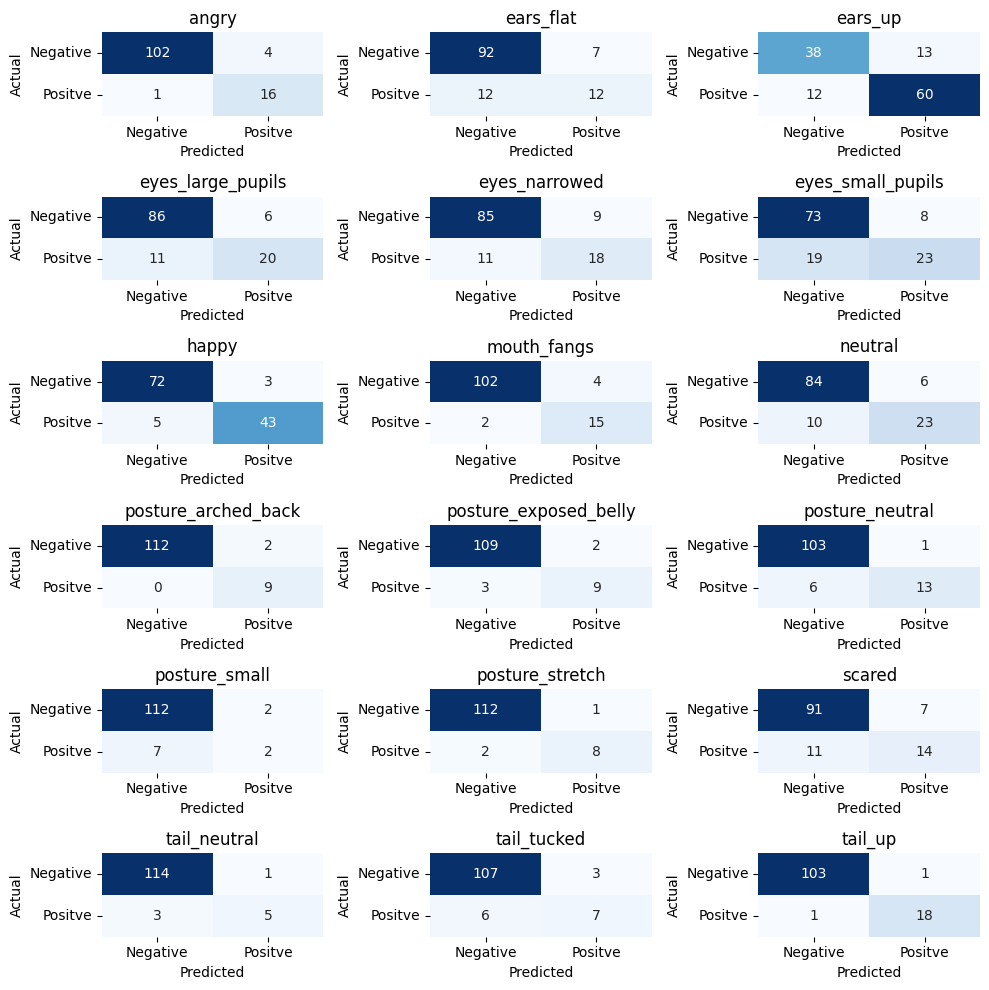

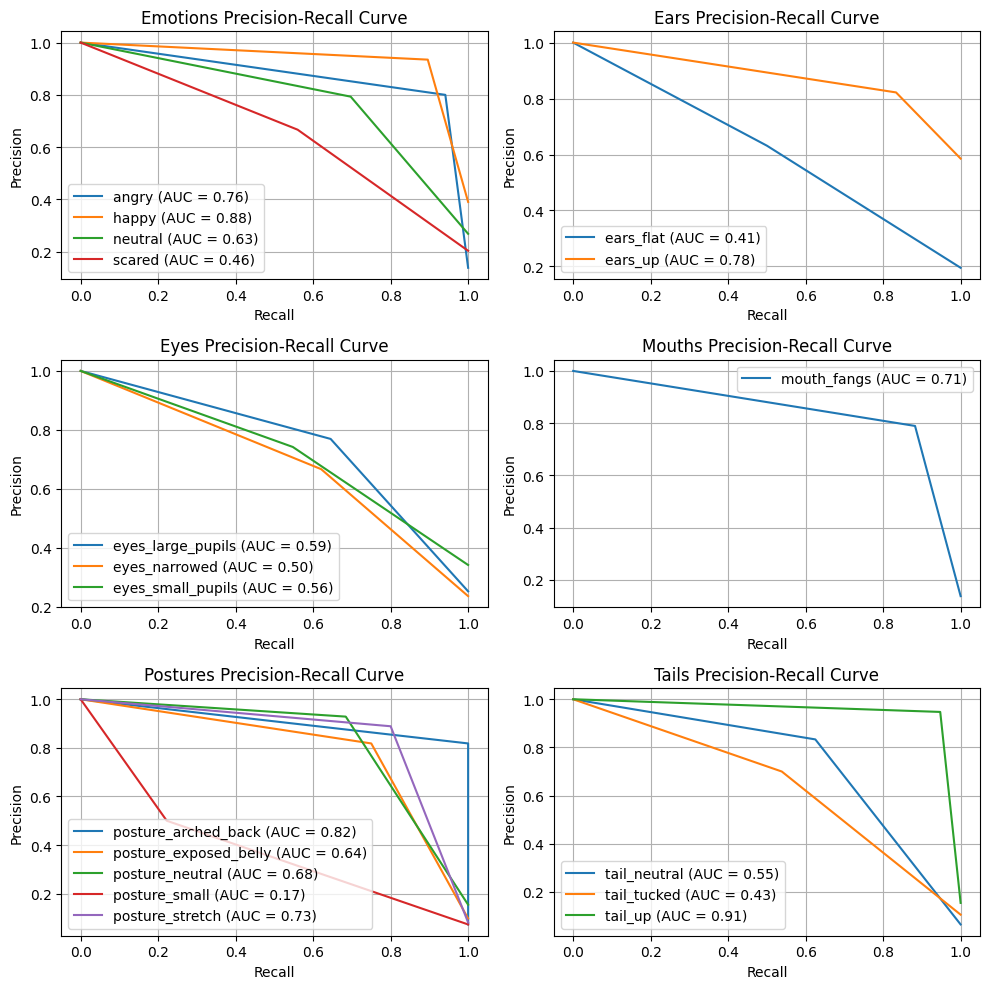

In [26]:
# Get ground truth labels
labels_true = df_test.drop(columns=['filename']).values

# Print predictions
binary_pred = (pred > 0.5).astype(int)
#print('Prediction Probabilities:\n', pred)
#print('\nBinary Predictions:\n', binary_pred)

# Calculate metrics
subset_accuracy = accuracy_score(labels_true, binary_pred)
precision, recall, f1, _ = precision_recall_fscore_support(labels_true, binary_pred, average=None)
hamming = hamming_loss(labels_true, binary_pred)
zero_one = zero_one_loss(labels_true, binary_pred)

# Display metrics
print(f'\nSubset Accuracy: {subset_accuracy:.4f}')
#print(f'Precision per label: {precision}')
#print(f'Recall per label: {recall}')
#print(f'F1 Score per label: {f1}')
print(f'Average Precision: {precision.mean():.4f}')
print(f'Average Recall: {recall.mean():.4f}')
print(f'Average F1 Score: {f1.mean():.4f}')
print(f'Hamming Loss: {hamming:.4f}')
print(f'Zero-One Loss: {zero_one:.4f}')


# Visualizations
# Class sets
emotions = ['angry', 'happy', 'neutral', 'scared']
ears = ['ears_flat', 'ears_up']
eyes = ['eyes_large_pupils', 'eyes_narrowed', 'eyes_small_pupils']
mouths = ['mouth_fangs']
postures = ['posture_arched_back', 'posture_exposed_belly', 'posture_neutral', 'posture_small', 'posture_stretch']
tails = ['tail_neutral', 'tail_tucked', 'tail_up']

# Confusion matrix
confusion_matrices = multilabel_confusion_matrix(labels_true, binary_pred)
classification_report = skm.classification_report(labels_true, binary_pred, target_names=DATASET_COLS)
print('\nClassification Report:\n', classification_report)
plot_multi_cm(confusion_matrices, DATASET_COLS)

# AUC-PR
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

plot_multi_auc_pr(axes[0], 'Emotions', emotions, labels_true, binary_pred)
plot_multi_auc_pr(axes[1], 'Ears', ears, labels_true, binary_pred)
plot_multi_auc_pr(axes[2], 'Eyes', eyes, labels_true, binary_pred)
plot_multi_auc_pr(axes[3], 'Mouths', mouths, labels_true, binary_pred)
plot_multi_auc_pr(axes[4], 'Postures', postures, labels_true, binary_pred)
plot_multi_auc_pr(axes[5], 'Tails', tails, labels_true, binary_pred)

plt.tight_layout()
plt.show()

# Save

In [27]:
# Save classification report
report = skm.classification_report(labels_true, binary_pred, target_names=DATASET_COLS, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

#df_report.to_csv(f'{model_dir}/reports/emeowtionsv1.csv')  # Local
df_report.to_csv('/content/models/reports/emeowtionsv6_7.csv') # Colab

                       precision    recall  f1-score  support
angry                   0.800000  0.941176  0.864865     17.0
ears_flat               0.631579  0.500000  0.558140     24.0
ears_up                 0.821918  0.833333  0.827586     72.0
eyes_large_pupils       0.769231  0.645161  0.701754     31.0
eyes_narrowed           0.666667  0.620690  0.642857     29.0
eyes_small_pupils       0.741935  0.547619  0.630137     42.0
happy                   0.934783  0.895833  0.914894     48.0
mouth_fangs             0.789474  0.882353  0.833333     17.0
neutral                 0.793103  0.696970  0.741935     33.0
posture_arched_back     0.818182  1.000000  0.900000      9.0
posture_exposed_belly   0.818182  0.750000  0.782609     12.0
posture_neutral         0.928571  0.684211  0.787879     19.0
posture_small           0.500000  0.222222  0.307692      9.0
posture_stretch         0.888889  0.800000  0.842105     10.0
scared                  0.666667  0.560000  0.608696     25.0
tail_neu

In [28]:
# Save model
# emeowtions_model.save(f'{model_dir}/checkpoints/emeowtionsv1.keras')  # Local
emeowtions_model.save('/content/models/checkpoints/emeowtionsv6_7.keras') # Colab